<a href="https://colab.research.google.com/github/Lucia1009/TFG-Plataforma-para-la-prediccion-de-potencia-electrica-generada-en-parques-eolicos/blob/desarrollo/modelos/Comparacion_modelos_series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openmeteo-requests -q
!pip install requests-cache retry-requests numpy pandas -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 621.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.1 MB/s eta 0:00:00


In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry

import sys

# Cargar el histórico

In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	"models": "best_match"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()


hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m



historico_df = pd.DataFrame(data = hourly_data)


# No hay nan, pero por si acaso
historico_df.dropna(inplace = True)

historico_df['wd_sin_10m'] = np.sin(historico_df['wind_direction_10m']*np.pi/180)
historico_df['wd_cos_10m'] = np.cos(historico_df['wind_direction_10m']*np.pi/180)


historico_df.head()

Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m,wind_speed_10m,wind_direction_10m,wd_sin_10m,wd_cos_10m
0,2023-01-01 00:00:00+00:00,15.3085,30.532158,232.184204,-0.789986,-0.613125
1,2023-01-01 01:00:00+00:00,15.7085,30.699368,230.710602,-0.773958,-0.633237
2,2023-01-01 02:00:00+00:00,15.7585,31.259941,231.546265,-0.783111,-0.621882
3,2023-01-01 03:00:00+00:00,15.8585,28.394392,230.659500,-0.773392,-0.633928
4,2023-01-01 04:00:00+00:00,15.8085,28.266304,223.451889,-0.687745,-0.725952




---


# Datos de los modelos
Los modelos seleccionados son:

['ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km']

1. *ECMWF IFS 0.4°*
2. *NCEP GFS Global 0.11°/0.25°*
3. *JMA GSM*
4. *DWD ICON Global*
5. *DWD ICON EU*
6. *DWD ICON D2*
7. *GEM Global*
8. *UK Met Office Global 10km*
9. *Météo-France ARPEGE Europe*
10. *Météo-France AROME France HD*




In [4]:
rosa='\033[95m'
fin='\033[0m'

lista_modelos=['ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km']

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	"models": lista_modelos
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
models=dict()
for response, mod in zip(responses, lista_modelos):

  print(f"{rosa}Model {mod}{fin}")  #Imprime con colores
  print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s\n")


  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe.dropna(inplace = True)

  hourly_dataframe['wd_sin_10m'] = np.sin(hourly_dataframe['wind_direction_10m']*np.pi/180)
  hourly_dataframe['wd_cos_10m'] = np.cos(hourly_dataframe['wind_direction_10m']*np.pi/180)

  models[mod]=hourly_dataframe
  print(hourly_dataframe.iloc[0], '\n\n')

print(len(models))
print(models.keys())

Model ecmwf_ifs04
Coordinates 52.40000915527344°N 13.600006103515625°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s

date                  2023-01-01 00:00:00+00:00
temperature_2m                             15.7
wind_speed_10m                        29.671074
wind_direction_10m                   234.381424
wd_sin_10m                            -0.812912
wd_cos_10m                            -0.582386
Name: 0, dtype: object 


Model gfs_global
Coordinates 52.54148864746094°N 13.359375°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s

date                  2023-01-01 00:00:00+00:00
temperature_2m                          15.0585
wind_speed_10m                        28.954834
wind_direction_10m                   231.562668
wd_sin_10m                            -0.783289
wd_cos_10m                            -0.621658
Name: 0, dtype: object 


Model jma_gsm
Coordinates 52.5°N 13.5°E
Elevation 38.0 m asl
Timezone None None
Timezone dif

In [5]:
# todos=historico_df.copy()
# for mod in models.keys():
#   todos=todos.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)

# todos.head(20)




---

# Obtener las métricas de cada modelo

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
atributos=['temperature_2m', 'wind_speed_10m', 'wd_sin_10m', 'wd_cos_10m']
scores=dict()

for mod in models.keys():

  print(f"\n{rosa}Model {mod}{fin}")
  scores[mod]=dict()

  hist_df=historico_df.copy()

  for atributo in atributos:
    datos_trabajo=hist_df.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)
    datos_trabajo.dropna(inplace=True)

    y_true=datos_trabajo[atributo]
    y_pred=datos_trabajo[atributo+f"_{mod}"]
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{atributo}: mse: {mse}, mae: {mae}, r2: {r2}")
    scores[mod][atributo]={'mse':mse, 'mae':mae, 'r2':r2}



Model ecmwf_ifs04
temperature_2m: mse: 0.4619382619857788, mae: 0.4823457896709442, r2: 0.9927635192871094
wind_speed_10m: mse: 5.80845832824707, mae: 1.7880427837371826, r2: 0.8671864867210388
wd_sin_10m: mse: 0.05272318795323372, mae: 0.11081628501415253, r2: 0.9087446331977844
wd_cos_10m: mse: 0.05888199061155319, mae: 0.12762387096881866, r2: 0.8424572944641113

Model gfs_global
temperature_2m: mse: 2.1257147789001465, mae: 1.0749601125717163, r2: 0.9666996002197266
wind_speed_10m: mse: 7.527532577514648, mae: 2.0643346309661865, r2: 0.8278789520263672
wd_sin_10m: mse: 0.0777411162853241, mae: 0.14676356315612793, r2: 0.8654426336288452
wd_cos_10m: mse: 0.08313652873039246, mae: 0.16648633778095245, r2: 0.7775626182556152

Model jma_gsm
temperature_2m: mse: 1.9752190113067627, mae: 1.0772653818130493, r2: 0.9690571427345276
wind_speed_10m: mse: 11.515176773071289, mae: 2.565857410430908, r2: 0.7366992831230164
wd_sin_10m: mse: 0.07519793510437012, mae: 0.1445075273513794, r2: 0.86

# Histograma de resultados

<ipython-input-28-67142870b193>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  model_colors = plt.cm.get_cmap('viridis', len(lista_modelos))


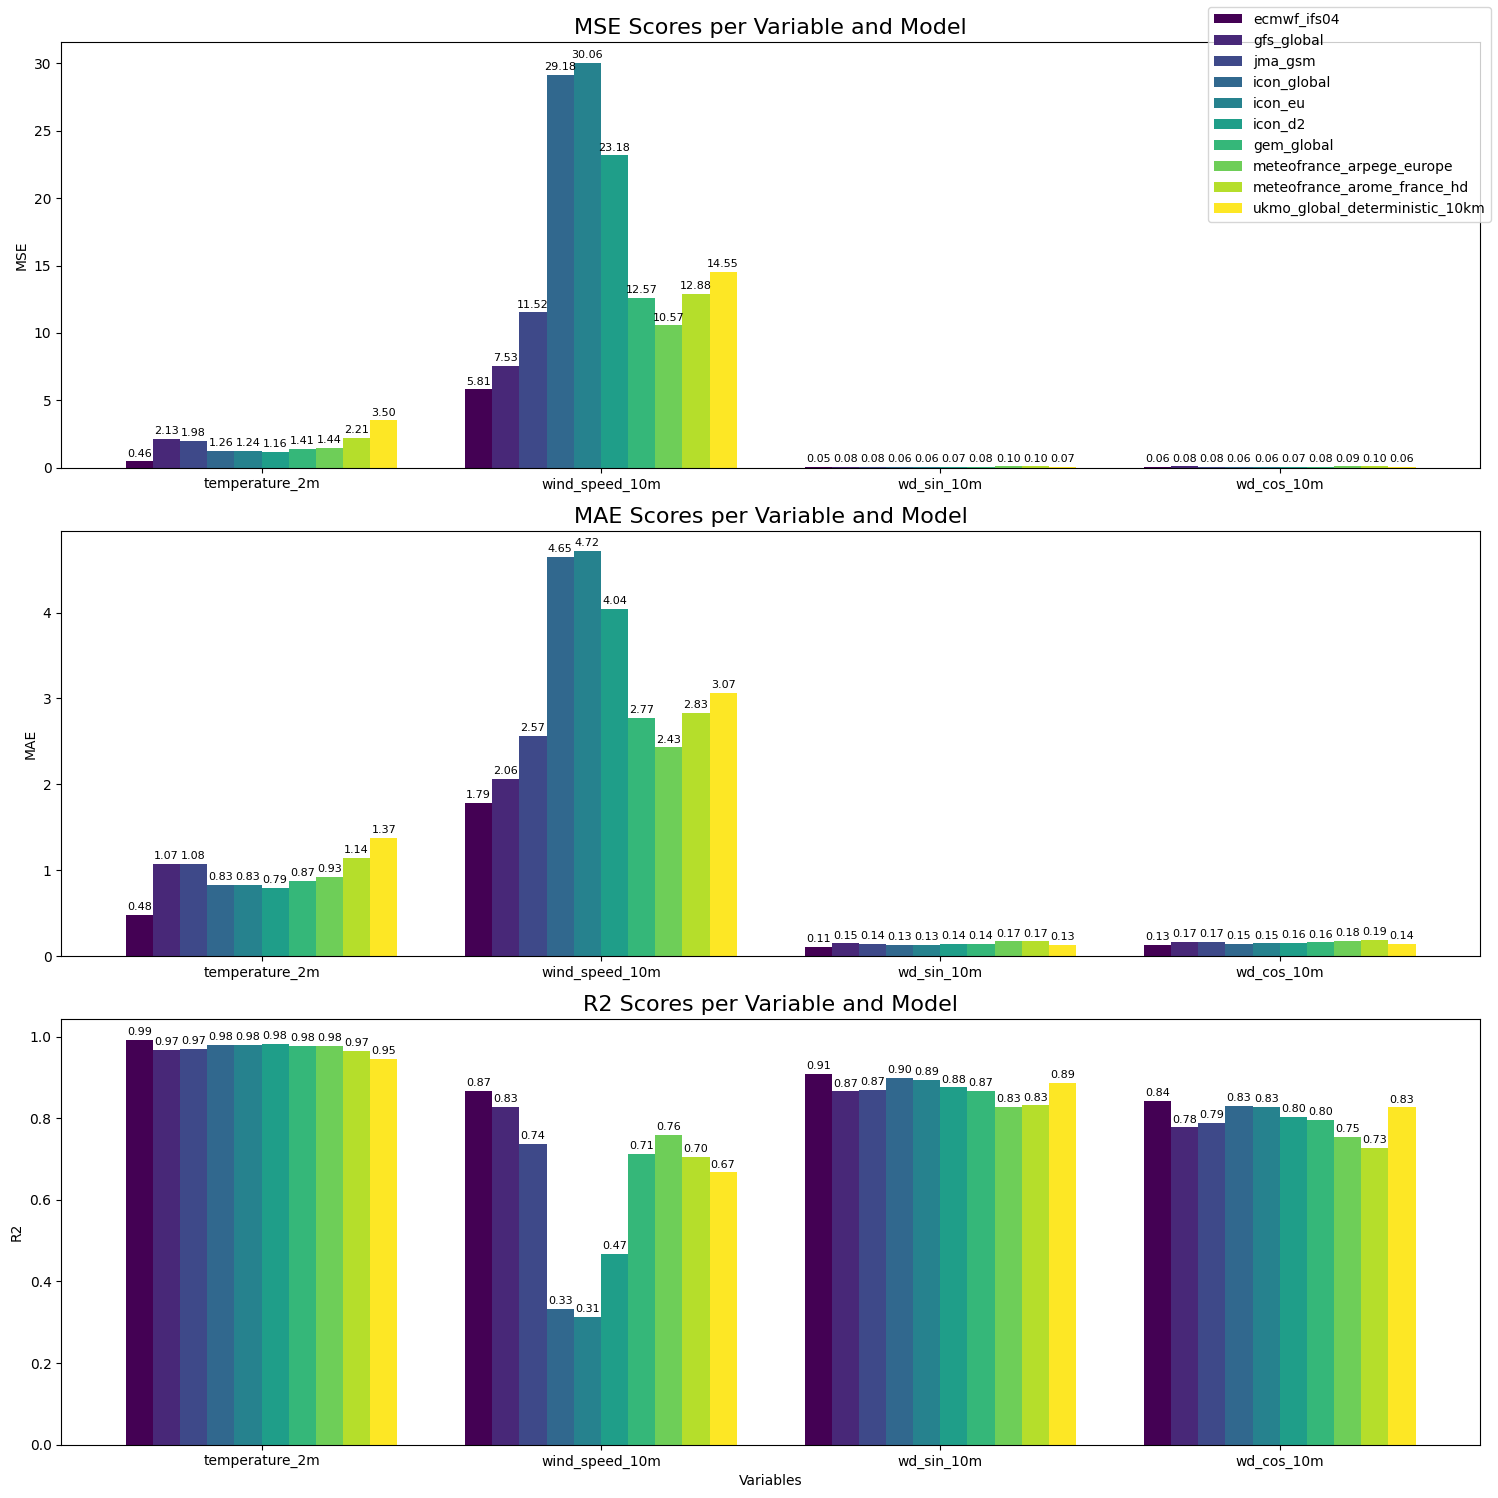

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

# Define variables
variables = ['temperature_2m', 'wind_speed_10m', 'wd_sin_10m', 'wd_cos_10m']
lista_modelos = list(scores.keys())

# Define colors for each model
model_colors = plt.cm.get_cmap('viridis', len(lista_modelos))
model_colors = [model_colors(i) for i in range(len(lista_modelos))]
model_colors_dict = dict(zip(lista_modelos, model_colors))

# Define metrics
metrics = ['mse', 'mae', 'r2'] # Changed to lowercase

# Define the bar width and position offset for each model
bar_width = 0.8 / len(lista_modelos)

# Calculate the positions for each bar
def calculate_bar_positions(variable_index, model_index):
    group_center = variable_index
    offset = (model_index - len(lista_modelos) / 2 + 0.5) * bar_width
    return group_center + offset

# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Loop through each metric and variable, and plot the bars
for metric_index, metric in enumerate(metrics):
    for variable_index, variable in enumerate(variables):
        for model_index, model in enumerate(lista_modelos):

            score = scores[model][variable][metric] # Access using metric name
            bar_position = calculate_bar_positions(variable_index, model_index)
            bars = axes[metric_index].bar(bar_position, score, width=bar_width, color=model_colors_dict[model], label=model if variable_index == 0 else "")
            axes[metric_index].bar_label(bars, fmt='%.2f', label_type='edge', padding=2, fontsize=8)

    axes[metric_index].set_ylabel(metric.upper()) # Convert to uppercase for label
    axes[metric_index].set_title(f'{metric.upper()} Scores per Variable and Model', fontsize=16)
    # Set the x-axis labels and ticks for each subplot
    axes[metric_index].set_xticks(range(len(variables)))
    axes[metric_index].set_xticklabels(variables)


# Set the x-axis label for the bottom plot
axes[-1].set_xlabel("Variables")

# Add a legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Guardar plot
plt.savefig('comparacion_modelos_series_temporales.png', dpi=300)



---
# Comparación 1 hora antes


In [9]:
atributos=['temperature_2m', 'wind_speed_10m', 'wd_sin_10m', 'wd_cos_10m']
scores_atraso=dict()

for mod in models.keys():

  print(f"\n{rosa}Model {mod}{fin}")
  scores_atraso[mod]=dict()

  hist_df=historico_df.copy()

  for atributo in atributos:
    # Atraso una hora todos los datos del modelo
    datos_atraso=models[mod].copy()
    datos_atraso['date']=datos_atraso['date']-pd.Timedelta(hours=1)



    datos_trabajo=hist_df.merge(datos_atraso, on="date", how="left", suffixes=("", f"_{mod}"),)
    datos_trabajo.dropna(inplace=True)
    y_true=datos_trabajo[atributo]
    y_pred=datos_trabajo[atributo+f"_{mod}"]
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{atributo}: mse: {mse}, mae: {mae}, r2: {r2}")
    scores_atraso[mod][atributo]={'mse':mse, 'mae':mae, 'r2':r2}







Model ecmwf_ifs04
temperature_2m: mse: 0.9869143962860107, mae: 0.7247905731201172, r2: 0.984538733959198
wind_speed_10m: mse: 6.92162561416626, mae: 1.947131633758545, r2: 0.8417366743087769
wd_sin_10m: mse: 0.06639663875102997, mae: 0.1288427710533142, r2: 0.8850822448730469
wd_cos_10m: mse: 0.06735342741012573, mae: 0.14224213361740112, r2: 0.8197907209396362

Model gfs_global
temperature_2m: mse: 2.4935991764068604, mae: 1.1913269758224487, r2: 0.9609346389770508
wind_speed_10m: mse: 8.530692100524902, mae: 2.1994199752807617, r2: 0.8049453496932983
wd_sin_10m: mse: 0.08869701623916626, mae: 0.16204994916915894, r2: 0.8464852571487427
wd_cos_10m: mse: 0.09141244739294052, mae: 0.18112532794475555, r2: 0.7554188966751099

Model jma_gsm
temperature_2m: mse: 1.7303211688995361, mae: 1.0026085376739502, r2: 0.9728923439979553
wind_speed_10m: mse: 11.633042335510254, mae: 2.590961456298828, r2: 0.7340099215507507
wd_sin_10m: mse: 0.07990960776805878, mae: 0.14898048341274261, r2: 0.861

In [10]:
verde='\033[92m'  #Mejor con los datos reales del momento
rojo='\033[91m'   #Mejor con los datos del momento anterior

for mod in models.keys():
  print(f"\n\n\n{rosa}Model {mod}{fin}")
  for atributo in atributos:
    print(f"\n{atributo}")
    for metrica in scores_atraso[mod][atributo]: #iteramos por los nombres de las métricas
      resta=scores[mod][atributo][metrica]-scores_atraso[mod][atributo][metrica]
      porcentaje=resta/scores[mod][atributo][metrica]
      if metrica != 'r2' and resta>0 or metrica == 'r2' and resta<0:
         print(f'{rojo}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)
      else:
         print(f'{verde}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)





Model ecmwf_ifs04

temperature_2m
resta mse -0.5249761343002319 porcentaje -1.136463847015976
resta mae -0.24244478344917297 porcentaje -0.502636881343089
resta r2 0.008224785327911377 porcentaje 0.00828473767228825

wind_speed_10m
resta mse -1.1131672859191895 porcentaje -0.19164591067233003
resta mae -0.1590888500213623 porcentaje -0.08897373791518075
resta r2 0.025449812412261963 porcentaje 0.02934756572198385

wd_sin_10m
resta mse -0.01367345079779625 porcentaje -0.25934415820843026
resta mae -0.018026486039161682 porcentaje -0.16267000862607414
resta r2 0.02366238832473755 porcentaje 0.026038545329805023

wd_cos_10m
resta mse -0.00847143679857254 porcentaje -0.14387144032644789
resta mae -0.014618262648582458 porcentaje -0.11454175882311252
resta r2 0.022666573524475098 porcentaje 0.0269053086410669



Model gfs_global

temperature_2m
resta mse -0.36788439750671387 porcentaje -0.17306385652409056
resta mae -0.11636686325073242 porcentaje -0.10825226153958245
resta r2 0.00576496